### Generate data 

# PyTorch RNN MNIST example 

### Moshe Wasserblat <br><br>March 2020

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms

BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

### Exploring the dataset

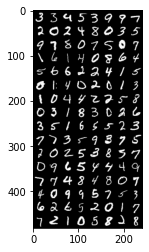

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

### Init Model 

In [0]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10



### Model Arch

In [0]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output


### Senity test before training

In [49]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 0.0874, -0.0170, -0.1666,  0.0322,  0.0733,  0.1388, -0.0102,  0.1297,
          0.1259, -0.0258],
        [ 0.0811, -0.0275, -0.1655,  0.0250,  0.0709,  0.1457, -0.0069,  0.1224,
          0.1355, -0.0238],
        [ 0.1172, -0.0244, -0.1849,  0.0312,  0.0244,  0.1237, -0.0487,  0.1380,
          0.1148,  0.0061],
        [ 0.0798, -0.0198, -0.1623,  0.0293,  0.0629,  0.1430, -0.0057,  0.1266,
          0.1276, -0.0300],
        [ 0.0839, -0.0181, -0.1614,  0.0337,  0.0658,  0.1375, -0.0100,  0.1243,
          0.1367, -0.0281],
        [ 0.0872, -0.0212, -0.1660,  0.0320,  0.0610,  0.1439, -0.0075,  0.1277,
          0.1246, -0.0239],
        [ 0.0821, -0.0155, -0.1636,  0.0342,  0.0616,  0.1506, -0.0064,  0.1297,
          0.1268, -0.0252],
        [ 0.0834, -0.0252, -0.1631,  0.0251,  0.0616,  0.1496, -0.0121,  0.1205,
          0.1274, -0.0195],
        [ 0.0811, -0.0156, -0.1650,  0.0290,  0.0654,  0.1387, -0.0093,  0.1283,
          0.1256, -0.0262],
        [ 0.1046, -

### Training

In [0]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

### Training:  1. Reset the gradients 2. Forward pass 3. Calc loss 4. Backward pass 5. One step of the optimizer

In [51]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.9107 | Train Accuracy: 69.73
Epoch:  1 | Loss: 0.3790 | Train Accuracy: 88.73
Epoch:  2 | Loss: 0.2581 | Train Accuracy: 92.55
Epoch:  3 | Loss: 0.2030 | Train Accuracy: 94.34
Epoch:  4 | Loss: 0.1827 | Train Accuracy: 94.93
Epoch:  5 | Loss: 0.1550 | Train Accuracy: 95.67
Epoch:  6 | Loss: 0.1371 | Train Accuracy: 96.24
Epoch:  7 | Loss: 0.1291 | Train Accuracy: 96.51
Epoch:  8 | Loss: 0.1198 | Train Accuracy: 96.70
Epoch:  9 | Loss: 0.1180 | Train Accuracy: 96.80


### Test

In [52]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 97.26
